# Working with submodels

In this notebook we will use pycollimator to optimize a PID controller for the cart pole model that you can find in our public projects. This will demonstrate how to download a submodel and use it in a model defined locally. Finally we will upload the resulting controller (as a submodel) and full model back to the Dashboard.

## Setup

### CartPole project

First, head to the [`DataBookUW - Chapter 8 (continuous)` project page](https://app.collimator.ai/projects/f2fabfc5-f980-4def-b810-6e4f434a9d31) on the Dashboard and copy it to your projects with the name `CartPole`.

<img src="../media/copy-my-projects.png" alt="copy">

<img src="../media/cartpole-project.png" alt="copy">

### Connecting to the Collimator application

To interact with the Collimator cloud application using the pycollimator package, you must first generate an API key from the Dashboard:

<img src="../media/settings.png" alt="Settings" style="width: 200px;"/>

<img src="../media/generate-api-key.png" alt="API key" style="width: 600px;"/>

When you generate the key, it is automatically copied to your system clipboard for you to paste into your code.

> **Note:** If you overwrite your clipboard contents after leaving the API Keys tab, you will no longer be able to see or copy your key and will have to generate a new one.

Import `dashboard` from the `collimator` package, and paste your API key as the argument to the `set_api_token` call at the beginning of your code:

In [1]:
from functools import partial

import collimator
from collimator import DiagramBuilder, dashboard, library, simulate, Parameter
from collimator.dashboard.serialization.model_json import Configuration, Workspace, WorkspaceDataFile
from collimator.simulation import SimulatorOptions
from collimator.models.cartpole import animate_cartpole

import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

dashboard.api.set_api_token("<YOUR_API_TOKEN>")

Note that you may also set the API token through the environment variable `COLLIMATOR_API_TOKEN`.

## Downloading the project

In [2]:
collimator.set_backend("jax")  # Need for autodiff
project = dashboard.project.get_project_by_name("CartPole")

10:28:43.933 - [collimator.dashboard.project][INFO]: Downloading project 8f12fdf5-f3b1-47aa-93ad-81d0f7c5a412...
10:28:44.140 - [collimator.dashboard.project][INFO]: Project dir: /Users/anthony/collimator-ai/collimator/src/lib/wildcat/docs/examples
10:28:48.230 - [collimator.dashboard.project][INFO]: Registering submodel PIDController
10:28:48.231 - [collimator.dashboard.project][INFO]: Registering submodel NoiseFromCovariance
10:28:48.232 - [collimator.dashboard.project][INFO]: Registering submodel LQRController
10:28:48.232 - [collimator.dashboard.project][INFO]: Registering submodel KalmanFilter
10:28:48.233 - [collimator.dashboard.project][INFO]: Registering submodel Impulse
10:28:48.233 - [collimator.dashboard.project][INFO]: Registering submodel CartPole
10:28:48.430 - [collimator.dashboard.project][INFO]: Evaluating WorkspaceDataFile(file_name='cartpole_init.py')
10:28:49.050 - [collimator.dashboard.project][INFO]: Evaluating WorkspaceDataFile(file_name='cartpole_init.py')
10:28

## Submodel for PID controller

For demonstration purposes we will create a simple submodel that only contains a `PIDDiscrete` block. 

In [3]:
def make_pid_controller(instance_name, parameters, dt=0.1):
    builder = DiagramBuilder()
    pid = library.PIDDiscrete(name="PID", dt=dt, **parameters)
    builder.add(pid)
    builder.export_input(pid.input_ports[0])
    builder.export_output(pid.output_ports[0])
    return builder.build(name=instance_name)

project.save_submodel(
    make_pid_controller,
    "PIDController",
    [
        Parameter(name="kp", value=0.0),
        Parameter(name="ki", value=0.0),
        Parameter(name="kd", value=0.0),
    ],
)

# instantiate the submodel so that we can use it in our local model.
controller = project.create_submodel_instance(
    "PIDController", "PIDControllerInstance",
    instance_parameters={"kp": 0.0, "ki": 0.0, "kd": 0.0}
)

10:28:52.564 - [collimator.dashboard.project][INFO]: Updating submodel 'PIDController' (f597149d-7d7a-43c1-967f-1e65f1117ec4)


## Model

The `CartPole` project contains a `CartPole` submodel that we will use in our model. The following code builds a model that consists of the cart pole, the PID controller, error calculation blocks and a cost function for optimization.

Our cost function simply calculates a weighted sum of the squared error of the angle `theta` and the position `x` and passes it to an Integrator block. Note that the reference position `q_ref_up` is defined in the init script `cartpole_init.py`.

In [4]:
def make_cost(x_weight=1.0, theta_weight=1.0):
    """Integral of squared error."""
    builder = DiagramBuilder()

    x_error = builder.add(library.IOPort(name="XError"))
    theta_error = builder.add(library.IOPort(name="ThetaError"))

    x_error_squared = builder.add(library.Power(2, name="XErrorSquared"))
    theta_error_squared = builder.add(library.Power(2, name="ThetaErrorSquared"))

    x_error_weight = builder.add(library.Gain(x_weight, name="XErrorWeight"))
    theta_error_weight = builder.add(library.Gain(theta_weight, name="ThetaErrorWeight"))
    error = builder.add(library.Adder(2, operators="++", name="Error"))

    cost_integral = builder.add(library.Integrator(0.0, name="CostIntegral"))

    builder.connect(x_error.output_ports[0], x_error_squared.input_ports[0])
    builder.connect(theta_error.output_ports[0], theta_error_squared.input_ports[0])
    builder.connect(x_error_squared.output_ports[0], x_error_weight.input_ports[0])
    builder.connect(theta_error_squared.output_ports[0], theta_error_weight.input_ports[0])
    builder.connect(x_error_weight.output_ports[0], error.input_ports[0])
    builder.connect(theta_error_weight.output_ports[0], error.input_ports[1])
    builder.connect(error.output_ports[0], cost_integral.input_ports[0])

    builder.export_input(x_error.input_ports[0], "XError")
    builder.export_input(theta_error.input_ports[0], "ThetaError")
    builder.export_output(cost_integral.output_ports[0], "cost")

    return builder.build(name="Cost")


def make_diagram(controller, cart_pole, cost, theta0, q_ref_up, name):
    builder = DiagramBuilder()
    builder.add(controller)
    builder.add(cart_pole)

    integrator = builder.add(library.Integrator([0, theta0, 0, 0], name="Integrator"))
    error = builder.add(library.Adder(2, operators="+-", name="Error"))

    reference = builder.add(library.Constant(q_ref_up, name="Reference"))

    # output of cart_pole is [dot_x, dot_theta, ddot_x, ddot_theta]
    # for this example we are only interested in dot_x and dot_theta
    x_error = builder.add(library.Slice("0", name="XError"))
    theta_error = builder.add(library.Slice("1", name="ThetaError"))


    # convert scalar to vector of shape (1,) - CartPole input expects a vector
    broadcast = builder.add(library.ScalarBroadcast(1, 0, name="Broadcast"))

    # cost function used for optimization
    cost_function = builder.add(cost)

    builder.connect(controller.output_ports[0], broadcast.input_ports[0])
    builder.connect(broadcast.output_ports[0], cart_pole.input_ports[1])

    builder.connect(cart_pole.output_ports[0], integrator.input_ports[0])
    builder.connect(integrator.output_ports[0], error.input_ports[0])
    builder.connect(integrator.output_ports[0], cart_pole.input_ports[0])
    builder.connect(reference.output_ports[0], error.input_ports[1])
    builder.connect(error.output_ports[0], x_error.input_ports[0])
    builder.connect(error.output_ports[0], theta_error.input_ports[0])
    builder.connect(theta_error.output_ports[0], controller.input_ports[0])
    builder.connect(x_error.output_ports[0], cost_function.input_ports[0])
    builder.connect(theta_error.output_ports[0], cost_function.input_ports[1])

    return builder.build(name=name)


def build_model(controller):
    cart_pole = project.create_submodel_instance("CartPole", "CartPoleInstance")
    q_ref_up = project.init_scripts["cartpole_init.py"].get_variable("q_ref_up")
    cost_function = make_cost(x_weight=0.1, theta_weight=1.0)
    theta0 = np.pi + 0.1

    return make_diagram(
        controller, cart_pole, cost_function, theta0, q_ref_up, name="CartPole_PID"
    )

diagram = build_model(controller)

Let's save the diagram to the Dashboard and check the resulting block diagrams in the UI.

In [5]:
project.save_model(
    diagram,
    configuration=Configuration(
        workspace=Workspace(init_scripts=[WorkspaceDataFile(file_name= "cartpole_init.py")])
    ),
)

10:29:04.907 - [collimator.dashboard.project][INFO]: Updating submodel 'PIDController' (f597149d-7d7a-43c1-967f-1e65f1117ec4)
10:29:05.775 - [collimator.dashboard.project][INFO]: Updating submodel 'CartPole' (0c37ab37-5392-4da4-9572-6b017db887e5)
10:29:07.127 - [collimator.dashboard.project][INFO]: Creating model 'CartPole_PID' (f3244d1a-f177-499b-a761-a79b6704cab5)


'f3244d1a-f177-499b-a761-a79b6704cab5'

<img src="../media/cartpole-pid-model.png" alt="cart-pole-pid" style="max-width: 600px">

<img src="../media/cartpole-pid-cost-model.png" alt="cart-pole-pid" style="max-width: 600px">

## Optimization

We will use the popular `scipy` library for optimization. 

In [6]:

def optimize_pid(diagram):
    t_span = (0.0, 2.0)
    options = SimulatorOptions(
        enable_autodiff=True,
        rtol=1e-6,
        atol=1e-8,
    )

    controller = diagram["PIDControllerInstance"]["PID"]
    cost_integral = diagram["Cost"]["CostIntegral"]

    @jax.jit
    def forward(k, context):
        controller_context = context[controller.system_id].with_parameters(
            {"kp": k[0], "ki": k[1], "kd": k[2]}
        )
        context = context.with_subcontext(controller.system_id, controller_context)
        results = simulate(diagram, context, t_span, options=options)
        return results.context[cost_integral.system_id].continuous_state

    k0 = jnp.array([1.0, 0.0, 0.0])
    context = diagram.create_context()

    forward(k0, context)

    res = minimize(partial(forward, context=context), k0, method="BFGS")

    return res.x

opt_params = optimize_pid(diagram)
print(opt_params)

10:29:11.189 - [collimator][INFO]: max_major_steps=100 based on smallest discrete period=0.1
10:29:11.190 - [collimator][INFO]: Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=Diagram(CartPole_PID, 9 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=True, max_checkpoints=16, supports_mass_matrix=False)
10:29:12.096 - [collimator][INFO]: max_major_steps=100 based on smallest discrete period=0.1
10:29:12.097 - [collimator][INFO]: Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_ste

[-309.11139084 -103.43909468  -94.97122   ]


Finally let's input the optimized gains in our model and check the results:

10:29:25.935 - [collimator][INFO]: max_major_steps=198 based on smallest discrete period=0.1
10:29:25.946 - [collimator][INFO]: Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=198, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(CartPole_PID, 9 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, max_checkpoints=16, supports_mass_matrix=False)


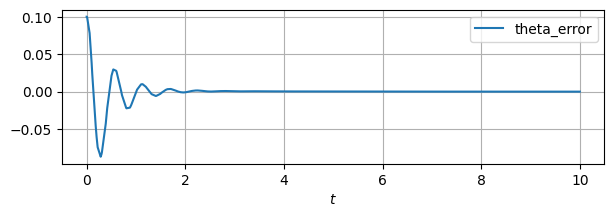

In [7]:
def show_results(diagram, kp, ki, kd):
    context = diagram.create_context()
    controller = diagram["PIDControllerInstance"]["PID"]
    integrator = diagram["Integrator"]
    controller_context = context[controller.system_id].with_parameters(
        {"kp": kp, "ki": ki, "kd": kd}
    )
    context = context.with_subcontext(controller.system_id, controller_context)

    results = simulate(
        diagram,
        context,
        (0.0, 10.0),
        recorded_signals={
            "x": integrator.output_ports[0],
            "theta_error": diagram["ThetaError"].output_ports[0],
        },
    )

    plt.figure(figsize=(7, 2))
    plt.plot(results.time, results.outputs["theta_error"], label='theta_error')
    plt.legend(loc='upper right')
    plt.xlabel("$t$")
    plt.grid()
    plt.show()

    x = results.outputs["x"]
    return animate_cartpole(results.time, x[:, 0], x[:, 1])


show_results(diagram, opt_params[0], opt_params[1], opt_params[2])

## Upload the optimized model to the Dashboard

In order to save the optimized model, we need to create a new instance of the PID controller submodel with the optimized gains and build a new model from that:

In [8]:
controller = project.create_submodel_instance(
    "PIDController", "PIDControllerInstance",
    instance_parameters={"kp": opt_params[0], "ki": opt_params[1], "kd": opt_params[2]}
)
optimized_diagram = build_model(controller)

project.save_model(
    optimized_diagram,
    configuration=Configuration(
        workspace=Workspace(init_scripts=[WorkspaceDataFile(file_name= "cartpole_init.py")])
    ),
)

10:29:32.862 - [collimator.dashboard.project][INFO]: Updating submodel 'PIDController' (f597149d-7d7a-43c1-967f-1e65f1117ec4)
10:29:33.804 - [collimator.dashboard.project][INFO]: Updating submodel 'CartPole' (0c37ab37-5392-4da4-9572-6b017db887e5)
10:29:34.766 - [collimator.dashboard.project][INFO]: Updating model 'CartPole_PID' (f3244d1a-f177-499b-a761-a79b6704cab5)


'f3244d1a-f177-499b-a761-a79b6704cab5'